In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

%reload_ext autoreload
%autoreload 2

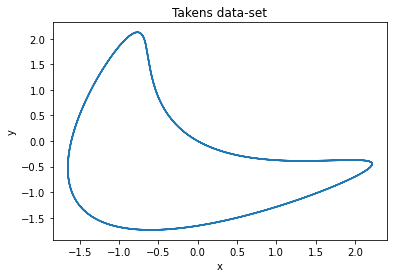

In [3]:
# original dataset
takens = np.loadtxt("./data/takens_1.txt")
plt.plot(takens[:, 0], takens[:, 1])
plt.title("Takens data-set")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("./figures/takens-data-set.png");

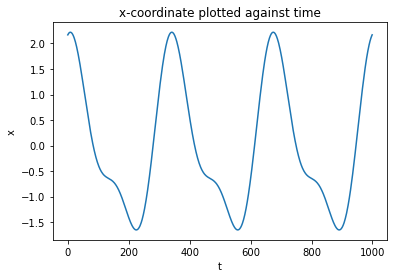

In [4]:
# plot first coordinate against time
plt.plot(np.arange(0, takens.shape[0], 1), takens[:, 0])
plt.title("x-coordinate plotted against time")
plt.xlabel("t")
plt.ylabel("x")
plt.savefig("./figures/x-plotted-against-time.png");

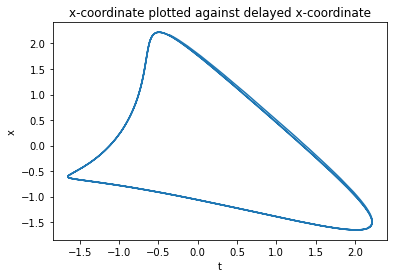

In [5]:
# time-delay embedding (delay is 100 rows by default)
x = []
y = []
delay = 100
for i in range(1000):
    x.append(takens[(i + delay) % 1000, 0])
    y.append(takens[i, 0])

# plotting
plt.plot(x, y)
plt.title("x-coordinate plotted against delayed x-coordinate")
plt.xlabel("t")
plt.ylabel("x")

In [6]:
# lorenz attractor
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def lorenz_attractor(state, _):
    x, y, z = state
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

In [7]:
# solve the ivp of lorenz up to a time
state0 = [10.0, 10.0, 10.0]
t_end = 100.0
t = np.linspace(0.0, t_end, 5000)

states = odeint(lorenz_attractor, state0, t)

In [8]:
# helper parameters
points_len = 5000
delta_n = 2

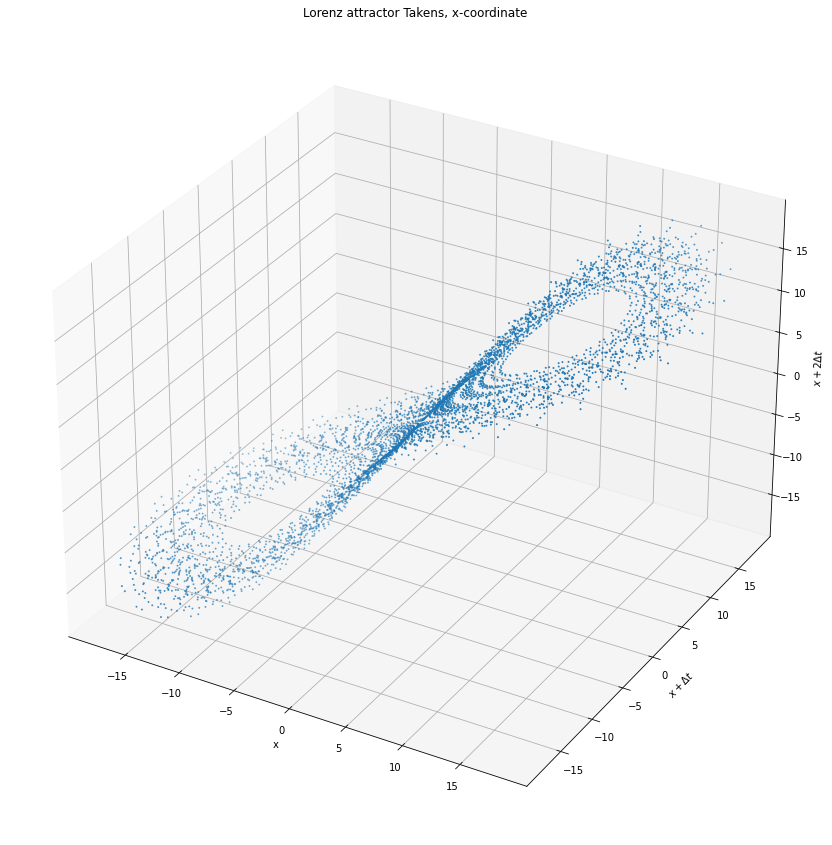

In [9]:
# we only observe x coordinates
x = states[:, 0]

# time-delay embedding
x_t = x[:points_len - 2 * delta_n]
y_t = x[delta_n: points_len - delta_n]
z_t = x[delta_n * 2: points_len]

# plotting
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel(r"$x + \Delta t$")
ax.set_zlabel(r"$x + 2\Delta t$")
ax.set_title("Lorenz attractor Takens, x-coordinate")
ax.scatter(x_t, y_t, z_t, s=1)

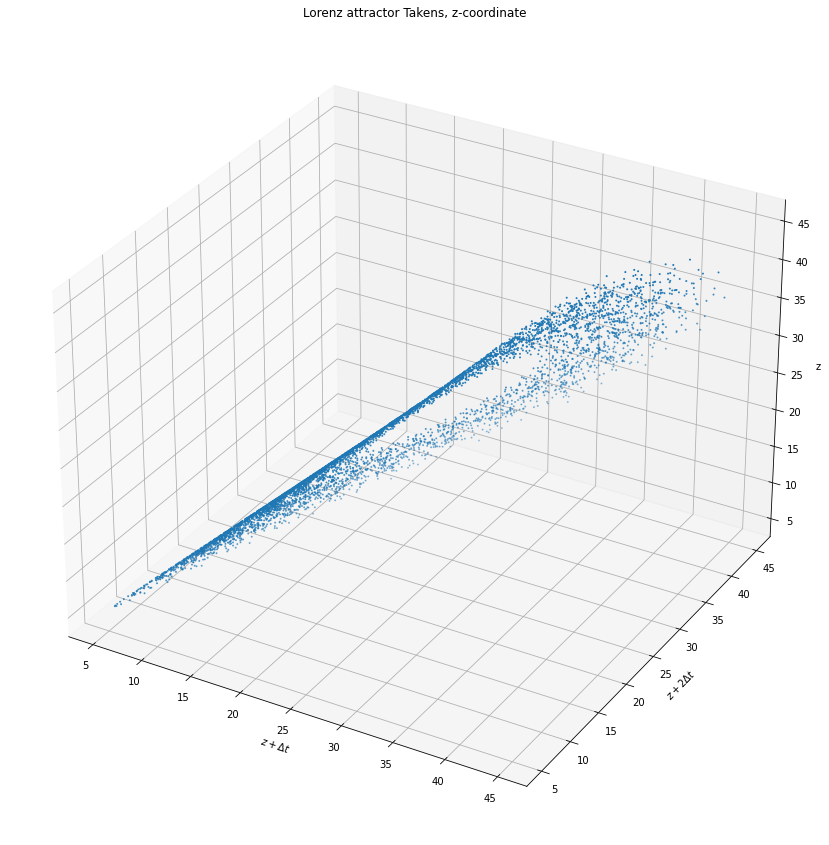

In [11]:
# we only observe z coordinates
z = states[:, 2]

# time-delay embedding
z_t = z[:points_len - 2 * delta_n]
x_t = z[delta_n: points_len - delta_n]
y_t = z[delta_n * 2: points_len]

# plotting
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection="3d")
ax.set_xlabel(r"$z + \Delta t$")
ax.set_ylabel(r"$z + 2\Delta t$")
ax.set_zlabel("z")
ax.set_title("Lorenz attractor Takens, z-coordinate")
ax.scatter(x_t, y_t, z_t, s=1)